In [1]:
import os
import sys
new_path = r'/usr/local/lib/python2.7/dist-packages'
sys.path.append(new_path)

import gym

In [2]:
env = gym.make('CartPole-v0')

In [3]:
import numpy as np
import random
import tensorflow as tf

seed_val = 111
np.random.seed(seed_val+1)
random.seed(seed_val+2)
tf.set_random_seed(seed_val+2)
env.seed(seed_val+3)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[114]

In [4]:
from collections import deque
from keras.layers import Dense
from keras.models import Sequential, clone_model
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as K
import time

Using TensorFlow backend.


In [5]:
import matplotlib.pyplot as plt
import pandas
%matplotlib inline

In [6]:
hyperparam_idx = 18

In [7]:
hyperparams = pandas.read_csv('hyperparams.csv')

gamma = hyperparams['gamma'][hyperparam_idx]
replay_buffer_length = hyperparams['replay_buffer_length'][hyperparam_idx]
learning_rate = hyperparams['learning_rate'][hyperparam_idx]
batch_size = hyperparams['batch_size'][hyperparam_idx]
target_reset_steps = hyperparams['target_reset_steps'][hyperparam_idx]
activation_function = hyperparams['activation_function'][hyperparam_idx]

In [8]:
eps_min = 0.01
n_episodes = 1000

# Neural net architecture, each layer must specify number of neurons and activation function
neural_net_arch = [[16, activation_function], [16, activation_function]]


N_ACTIONS = env.action_space.n

eps_schedule = np.append(np.linspace(1.0, eps_min, int(0.4*n_episodes)), eps_min * np.ones(n_episodes-int(0.4*n_episodes)))
states = deque(maxlen= int(replay_buffer_length))
actions = deque(maxlen= int(replay_buffer_length))
rewards = deque(maxlen= int(replay_buffer_length))
next_states = deque(maxlen= int(replay_buffer_length))
done_flags = deque(maxlen= int(replay_buffer_length))

In [9]:
# hyperparams

In [10]:
def huber_loss(target, prediction):
    error = prediction - target
    return K.mean(K.sqrt(1+K.square(error))-1, axis=-1)

def preprocess(img):
    return np.reshape(img, (1,4))

def select_action(q_model, cur_state, eps):
    if random.random() < eps:
        return random.choice(range(N_ACTIONS))
    else:
        return np.argmax(q_model.predict(cur_state))

def store_memory(states, actions, rewards, next_states, done_flags,
                 state, action, reward, next_state, done):
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    done_flags.append(done)
    
# def q_learning_update(gamma, alpha, cur_state, reward, next_state, action, q_vals):
#     target = reward + gamma * np.max(q_vals[next_state])
#     q_vals[cur_state][action] = (1 - alpha) * q_vals[cur_state][action] + alpha * target
    

def replay(q_target_model, q_model, states, actions, rewards, next_states, done_flags):

    minibatch_indices = random.sample(range(replay_buffer_length), batch_size)
    states_minibatch = np.reshape(np.array(states)[minibatch_indices], (batch_size, 4))
    actions_minibatch = np.array(actions)[minibatch_indices]
    rewards_minibatch = np.array(rewards)[minibatch_indices]
    next_states_minibatch = np.reshape(np.array(next_states)[minibatch_indices], (batch_size, 4))
    done_flags_minibatch = np.array(done_flags)[minibatch_indices]

#     from IPython.core.debugger import set_trace
#     set_trace()

    # y_minibatch = q_target_model.predict(next_states_minibatch)
    y_minibatch = np.zeros((batch_size, N_ACTIONS))
    y_minibatch[to_categorical(actions_minibatch, num_classes=N_ACTIONS).astype(np.bool)] = done_flags_minibatch.astype(np.float32) * -10.0 + np.invert(done_flags_minibatch).astype(np.float32) * (rewards_minibatch + gamma * np.max(q_target_model.predict(next_states_minibatch), axis=1))
    
    
    # y_minibatch currently gives one value for each state (corresponding to the Q_target for best action)
    # but to train we need a shape of (batch_size, n_actions) for the loss
    # setting the Loss[i] = 0 for all action_i except the best action
#     y_minibatch_one_hot = y_minibatch[:,None] * to_categorical(actions_minibatch, num_classes=N_ACTIONS)

    q_model.fit(x=states_minibatch, y=y_minibatch, verbose=0)

def reset_q_target(q_model):
    model_copy = clone_model(q_model)
    model_copy.set_weights(q_model.get_weights())
    return model_copy

def create_q_model():
    model = Sequential()
    if (len(neural_net_arch) >= 1):
        model.add(Dense(neural_net_arch[0][0], activation=neural_net_arch[0][1], input_dim=env.observation_space.shape[0]))
    if (len(neural_net_arch) >= 2):
        model.add(Dense(neural_net_arch[1][0], activation=neural_net_arch[1][1]))
    if (len(neural_net_arch) >= 3):
        model.add(Dense(neural_net_arch[2][0], activation=neural_net_arch[2][1]))
                  
    model.add(Dense(N_ACTIONS, activation='linear'))
    opt = optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=opt, loss='mse')
    # model.compile(optimizer=opt, loss=huber_loss)
    return model

In [11]:
q_model = create_q_model()
q_target_model = reset_q_target(q_model)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
global_steps = 0
ret=[]
q_vals=[]
eps_vals=[]

In [13]:
cur_state = preprocess(env.reset())
for i in range(replay_buffer_length):
    action = select_action(q_model, cur_state, 1) #Full exploration for replay buffer population
    next_state, reward, done, info = env.step(action)
    next_state = preprocess(next_state)
    store_memory(states, actions, rewards, next_states, done_flags,
                     cur_state, action, reward, next_state, done)
    if done:
        cur_state = preprocess(env.reset())
    cur_state = next_state

In [14]:
for episode in range(n_episodes):
    # preprocess state
    cur_state = preprocess(env.reset())
    reward_count = 0
    
    
    for t in range(300):
        global_steps += 1

        if global_steps % target_reset_steps == 0:
            q_target_model = reset_q_target(q_model)

        action = select_action(q_model, cur_state, eps_schedule[episode])
        next_state, reward, done, info = env.step(action)
        reward_count += reward
        
        if done:
            ret.append(t)
            q_vals.append(q_model.predict(cur_state)[0,action])
            eps_vals.append(eps_schedule[episode])
            
            next_state = np.zeros(cur_state.shape)
            store_memory(states, actions, rewards, next_states, done_flags,
                         cur_state, action, reward, next_state, done)
            
            if (episode % 10 == 0) or (reward_count > 180):
                print("Episode:", episode)
                if (reward_count > 180):
                    print("Reward:", reward_count)
                print("Avg Running Reward:", np.mean(ret[-10:-1]))
            break
        
        next_state = preprocess(next_state)
        store_memory(states, actions, rewards, next_states, done_flags,
                     cur_state, action, reward, next_state, done)
        
        cur_state = next_state
        
        replay(q_target_model, q_model, states, actions, rewards, next_states, done_flags)

Episode: 0
Avg Running Reward: nan


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 10
Avg Running Reward: 24.333333333333332
Episode: 20
Avg Running Reward: 19.88888888888889
Episode: 30
Avg Running Reward: 19.0
Episode: 40
Avg Running Reward: 21.555555555555557
Episode: 50
Avg Running Reward: 19.88888888888889
Episode: 60
Avg Running Reward: 27.666666666666668
Episode: 70
Avg Running Reward: 25.0
Episode: 80
Avg Running Reward: 18.88888888888889
Episode: 90
Avg Running Reward: 20.11111111111111
Episode: 100
Avg Running Reward: 20.555555555555557
Episode: 110
Avg Running Reward: 20.77777777777778
Episode: 120
Avg Running Reward: 17.666666666666668
Episode: 130
Avg Running Reward: 18.0
Episode: 140
Avg Running Reward: 26.11111111111111
Episode: 150
Avg Running Reward: 15.0
Episode: 160
Avg Running Reward: 21.22222222222222
Episode: 170
Avg Running Reward: 13.444444444444445
Episode: 180
Avg Running Reward: 21.88888888888889
Episode: 190
Avg Running Reward: 14.555555555555555
Episode: 200
Avg Running Reward: 21.444444444444443
Episode: 210
Avg Running Reward: 

Episode: 437
Reward: 200.0
Avg Running Reward: 198.11111111111111
Episode: 438
Reward: 200.0
Avg Running Reward: 198.11111111111111
Episode: 439
Reward: 200.0
Avg Running Reward: 198.11111111111111
Episode: 440
Reward: 198.0
Avg Running Reward: 198.11111111111111
Episode: 441
Reward: 200.0
Avg Running Reward: 197.88888888888889
Episode: 442
Reward: 189.0
Avg Running Reward: 197.88888888888889
Episode: 443
Reward: 198.0
Avg Running Reward: 196.66666666666666
Episode: 444
Reward: 200.0
Avg Running Reward: 196.44444444444446
Episode: 445
Reward: 200.0
Avg Running Reward: 196.44444444444446
Episode: 446
Reward: 200.0
Avg Running Reward: 197.33333333333334
Episode: 447
Reward: 200.0
Avg Running Reward: 197.33333333333334
Episode: 448
Reward: 200.0
Avg Running Reward: 197.33333333333334
Episode: 449
Reward: 200.0
Avg Running Reward: 197.33333333333334
Episode: 450
Reward: 200.0
Avg Running Reward: 197.55555555555554
Episode: 451
Reward: 200.0
Avg Running Reward: 197.55555555555554
Episode: 4

Episode: 594
Reward: 200.0
Avg Running Reward: 184.0
Episode: 595
Reward: 200.0
Avg Running Reward: 184.0
Episode: 596
Reward: 190.0
Avg Running Reward: 187.88888888888889
Episode: 597
Reward: 200.0
Avg Running Reward: 189.33333333333334
Episode: 598
Reward: 192.0
Avg Running Reward: 193.55555555555554
Episode: 600
Avg Running Reward: 189.33333333333334
Episode: 601
Reward: 200.0
Avg Running Reward: 188.77777777777777
Episode: 603
Reward: 200.0
Avg Running Reward: 182.55555555555554
Episode: 604
Reward: 188.0
Avg Running Reward: 182.55555555555554
Episode: 605
Reward: 199.0
Avg Running Reward: 181.22222222222223
Episode: 607
Reward: 200.0
Avg Running Reward: 176.44444444444446
Episode: 608
Reward: 200.0
Avg Running Reward: 177.33333333333334
Episode: 609
Reward: 200.0
Avg Running Reward: 180.66666666666666
Episode: 610
Avg Running Reward: 185.55555555555554
Episode: 611
Reward: 187.0
Avg Running Reward: 182.0
Episode: 617
Reward: 183.0
Avg Running Reward: 176.22222222222223
Episode: 61

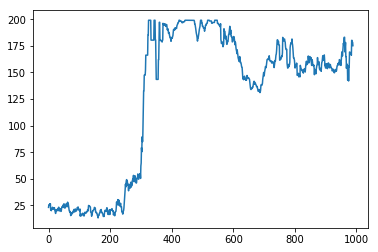

In [15]:
plt.plot([np.mean(ret[i-10:i]) for i in range(10, len(ret))])

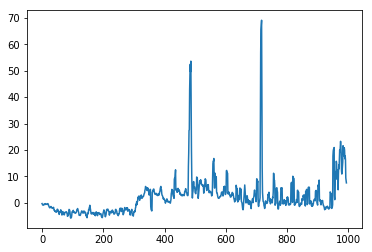

In [16]:
plt.plot([np.mean(q_vals[i-5:i]) for i in range(5, len(q_vals))])

In [17]:
logfile = pandas.DataFrame({'ret': ret, 'q_val': q_vals,
                            'gamma': gamma, 'epsilon': eps_vals,
                            'optimizer': 'Adam', 'optimizer_lr': learning_rate,
                            'replay_buffer_size': replay_buffer_length,
                            'batch_size': batch_size, 'episode': range(1,len(ret)+1),
                            'seed': seed_val, 'timestamp':int(time.time())})


for i in range(len(neural_net_arch)):
    logfile['layer{}_neurons'.format(i+1)] = neural_net_arch[i][0]
    logfile['layer{}_activation'.format(i+1)] = neural_net_arch[i][1]
logfile

,batch_size,episode,epsilon,gamma,optimizer,optimizer_lr,q_val,replay_buffer_size,ret,seed,timestamp,layer1_neurons,layer1_activation,layer2_neurons,layer2_activation
0,32,1,1.000000,0.99,Adam,0.001,0.243976,1000,12,111,1530006418,16,relu,16,relu
1,32,2,0.997519,0.99,Adam,0.001,0.213417,1000,17,111,1530006418,16,relu,16,relu
2,32,3,0.995038,0.99,Adam,0.001,-1.207367,1000,16,111,1530006418,16,relu,16,relu
3,32,4,0.992556,0.99,Adam,0.001,-0.436242,1000,14,111,1530006418,16,relu,16,relu
4,32,5,0.990075,0.99,Adam,0.001,-0.214832,1000,24,111,1530006418,16,relu,16,relu
5,32,6,0.987594,0.99,Adam,0.001,-0.841112,1000,15,111,1530006418,16,relu,16,relu
6,32,7,0.985113,0.99,Adam,0.001,-1.519421,1000,70,111,1530006418,16,relu,16,relu
7,32,8,0.982632,0.99,Adam,0.001,-0.720112,1000,15,111,1530006418,16,relu,16,relu
8,32,9,0.980150,0.99,Adam,0.001,-0.387367,1000,31,111,1530006418,16,relu,16,relu
9,32,10,0.977669,0.99,Adam,0.001,0.200309,1000,17,111,1530006418,16,relu,16,relu


In [18]:
logfile.to_csv("Cartpole/DQNwithTarget.csv", mode='a', header=False, index=False)

In [26]:
a = np.reshape(range(9), (3,3))

In [28]:
b = np.array(a)
b[2,2] = 100
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])